In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import random
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, resnet18
from matplotlib import pyplot as plt
import cv2


In [ ]:
N = 224
N_CLASSES = 2
SMOOTH = 0.1
LOSS = 'UANLL' # CE or UANLL
SEED = [42, 0, 17, 9, 3]
NUM_TTA_FOR_SEED = 20
MODEL = 'Res' # Unet encoder (UEn), ResNet 18 (Res), Efficient net b0 (Efb0), ResNet 18 with Dropout (ResDO)
RUN_TYPE = 'inference' # train or inference
AVERAGING = 'index'
STEP = ''
USE_NORM = False
TRANSFORMS = 0 # 0 - ColorJitter, 1 - RRC
USE_SCHEDULER = False

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    return g
    

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [4]:
class ClassDataset(Dataset):
    def __init__(self, dataframe, preload_transform=None, transform=None):
        self.dataframe = dataframe.dropna().reset_index()
        self.preload_transform = preload_transform
        self.transform = transform

        self.images = torch.zeros(len(dataframe), 3, N, N).float()
        
        for idx in range(len(self.dataframe)):
            image_path = self.dataframe.loc[idx, 'index']
            image = cv2.imread(f'images/{image_path}', cv2.IMREAD_GRAYSCALE)
            if self.preload_transform:
                self.images[idx] = self.preload_transform(torch.tensor(image.astype(np.float32) / 255).unsqueeze(0))
                if USE_NORM:
                    self.images[idx] -= self.images[idx].min()
                    self.images[idx] /= self.images[idx].max()

    def set_transform(self, transform):
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.images[idx])
        else:
            image = self.images[idx]
        if USE_NORM:
            return (image * 2) - 1, int(self.dataframe.loc[self.dataframe.index[idx], 'CTI_label'])
        else:
            return image, int(self.dataframe.loc[idx, 'CTI_label'])


In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 2 if LOSS == 'CE' else 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CEloss(nn.Module):
    def __init__(self,smoothing=SMOOTH, classes=N_CLASSES):
        super(CEloss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.clc = classes

    def forward(self,x,y):
        prob = nn.functional.softmax(x,1)

        with torch.no_grad():
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (self.clc - 1))
            yoh.scatter_(1, y.data.unsqueeze(1), self.confidence)
            
        log_prob = -1.0 * torch.log(prob)
        loss = yoh * log_prob #log_prob.gather(1, y.unsqueeze(1))
        loss = loss.mean()
        return loss


class UANLLloss(nn.Module):
    def __init__(self, smoothing=SMOOTH, classes=N_CLASSES):
        super(UANLLloss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.clc = classes
        
    def forward(self,x,y):
        logvar  = (x[:,self.clc:]) #** 2 
        prob = x[:,:self.clc]

        with torch.no_grad():
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (self.clc - 1))
            yoh.scatter_(1, y.data.unsqueeze(1), self.confidence)

        loss0 = ((yoh - prob) ** 2).sum(dim=1)
        loss = (torch.exp(-logvar) * loss0 + self.clc * logvar)

        return loss.mean()


class ClassModel(pl.LightningModule):
    def __init__(self):
        super(ClassModel, self).__init__()
        if MODEL == 'UEn':
            self.model = Encoder()
        elif MODEL == 'Res':
            self.model = resnet18(weights='IMAGENET1K_V1')
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=2 if LOSS == 'CE' else 3, bias=True)

        elif MODEL == 'ResDO':
            self.model = resnet18(weights='IMAGENET1K_V1')
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=2 if LOSS == 'CE' else 3, bias=True)
            self.model.maxpool = nn.Sequential(*[self.model.maxpool, nn.Dropout(p=0.1)])
            self.model.layer1.append(nn.Dropout(p=0.1))
            self.model.layer2.append(nn.Dropout(p=0.1))
            self.model.layer3.append(nn.Dropout(p=0.1))
            self.model.layer4.append(nn.Dropout(p=0.1))
            self.model.avgpool = nn.Sequential(*[self.model.avgpool, nn.Dropout(p=0.1)])
        elif MODEL == 'Efb0':
            self.model = efficientnet_b0(weights='IMAGENET1K_V1')
            self.model.classifier[1] = nn.Linear(in_features=self.model.classifier[1].in_features, out_features=2 if LOSS == 'CE' else 3, bias=True)
        self.criterion = UANLLloss() if LOSS == 'UANLL' else CEloss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)
        acc = (sm.argmax(1) == targets).sum() / len(targets)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        if USE_SCHEDULER:
            optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-3)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)
            return [optimizer], [scheduler]
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-4 if MODEL == 'UEn' else 1e-3)
        return optimizer


In [12]:
model = resnet18()

In [13]:

def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        # table.add_row([name, params])
        total_params += params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 11689512


11689512

In [ ]:
transform = transforms.Compose([
    v2.Resize((N, N)),
    v2.Grayscale(num_output_channels=3),
])

df = pd.read_csv('total.csv', header=[0, 1], index_col=0)

if RUN_TYPE == 'train':
    train_df = pd.concat([df['Kernal'][df['meta']['subset'] == 'train'][['CTI_label', 'LP_label']],
                          df['SuperDoctor'][df['meta']['subset'] == 'train'][['CTI_label', 'LP_label']],
                          df['Almaz123Almaz123'][df['meta']['subset'] == 'train'][['CTI_label', 'LP_label']],
                          df['Albert123Albert123'][df['meta']['subset'] == 'train'][['CTI_label', 'LP_label']]])

    val_df = pd.concat([df['Kernal'][df['meta']['subset'] == 'val'][['CTI_label', 'LP_label']],
                        df['SuperDoctor'][df['meta']['subset'] == 'val'][['CTI_label', 'LP_label']],
                        df['Almaz123Almaz123'][df['meta']['subset'] == 'val'][['CTI_label', 'LP_label']],
                        df['Albert123Albert123'][df['meta']['subset'] == 'val'][['CTI_label', 'LP_label']]])

    train_dataset = ClassDataset(train_df, preload_transform=transform)
    val_dataset = ClassDataset(val_df, preload_transform=transform)


In [ ]:
if RUN_TYPE == 'train':
    checkpoints = []
    best_scores = []

    for seed in SEED:
        g = seed_everything(seed)

        if TRANSFORMS == 0:
            transform_train = v2.Compose([
                v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
            ])
        else:
            transform_train = v2.Compose([
                v2.RandomResizedCrop(N, scale=(0.85, 1), antialias=True)
            ])

        train_dataset.set_transform(transform_train)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints/encoder',
            filename = f'class_{LOSS}_{seed}_{MODEL}_' + '{epoch:02d}-{val_acc:.3f}',
            save_top_k=1,
            mode='min',
        )

        logger = TensorBoardLogger("tb_logs", name=f'class_{LOSS}_{seed}_{MODEL}')

        model = ClassModel()

        trainer = pl.Trainer(
            max_epochs=100,
            callbacks=[checkpoint_callback],
            logger=logger,
            deterministic=True
        )

        trainer.fit(model, train_loader, val_loader)
        checkpoints.append(checkpoint_callback.best_model_path)
        best_scores.append(checkpoint_callback.best_model_score)


In [ ]:
if RUN_TYPE == 'train':
    print('Best val score:', torch.tensor(best_scores).mean().item())

In [13]:
if RUN_TYPE == 'inference':
    checkpoints = []
    all_checkpoints = os.listdir(f'checkpoints{STEP}/encoder')
    for i in all_checkpoints:
        if (LOSS in i) and (MODEL == i.split('_')[-3]):
            checkpoints.append(f'checkpoints{STEP}/encoder/{i}')

In [10]:
test_df = df['Kernal'][df['meta']['subset'] == 'test'][['CTI_label', 'LP_label']]

test_df1 = df['Kernal'][df['meta']['subset'] == 'test'][['CTI_label', 'LP_label']].fillna(-1)
test_df2 = df['SuperDoctor'][df['meta']['subset'] == 'test'][['CTI_label', 'LP_label']].fillna(-1)
test_df3 = df['Almaz123Almaz123'][df['meta']['subset'] == 'test'][['CTI_label', 'LP_label']].fillna(-1)
test_df4 = df['Albert123Albert123'][df['meta']['subset'] == 'test'][['CTI_label', 'LP_label']].fillna(-1)

mean_labels  = []
std_labels = []

for i in range(len(test_df)):
    tmp = []
    for j in [test_df1, test_df2, test_df3, test_df4]:
        if j['CTI_label'][i] >= 0:
            tmp.append(j['CTI_label'][i])
    mean_labels.append(np.sum(tmp))
    std_labels.append(np.std(tmp))

mean_labels = np.array(mean_labels)
std_labels = np.array(std_labels)

test_df1 = df['Kernal'][df['meta']['subset'] == 'test'][['CTI_value', 'LP_value']].fillna(0)
test_df2 = df['SuperDoctor'][df['meta']['subset'] == 'test'][['CTI_value', 'LP_value']].fillna(0)
test_df3 = df['Almaz123Almaz123'][df['meta']['subset'] == 'test'][['CTI_value', 'LP_value']].fillna(0)
test_df4 = df['Albert123Albert123'][df['meta']['subset'] == 'test'][['CTI_value', 'LP_value']].fillna(0)

mean_values  = []
std_values = []

for i in range(len(test_df)):
    tmp = []
    for j in [test_df1, test_df2, test_df3, test_df4]:
        if j['CTI_value'][i] > 0:
            tmp.append(j['CTI_value'][i])
    mean_values.append(np.mean(tmp))
    std_values.append(np.std(tmp))

mean_values = np.array(mean_values)
std_values = np.array(std_values)

if AVERAGING == 'class':
    test_df['CTI_label'][mean_labels >= 2] = 1
    test_df['CTI_label'][mean_labels < 2] = 0
else:
    test_df['CTI_label'][mean_values > 0.5] = 1
    test_df['CTI_label'][mean_values <= 0.5] = 0

/tmp/ipykernel_25044/1465421285.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if j['CTI_label'][i] >= 0:
/tmp/ipykernel_25044/1465421285.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tmp.append(j['CTI_label'][i])
/tmp/ipykernel_25044/1465421285.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if j['CTI_value'][i] > 0:
/tmp/ipykernel_25044/1465421285.py:34: FutureWarning: Series.__getitem__ treating keys as position

In [11]:
if RUN_TYPE == 'train':
    print(train_df['CTI_label'].value_counts(normalize=True))
    print(val_df['CTI_label'].value_counts(normalize=True))
print(test_df['CTI_label'].value_counts(normalize=True))


CTI_label
0.0    0.581818
1.0    0.418182
Name: proportion, dtype: float64


# Clean

/root/miniconda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_25044/1519742643.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  re

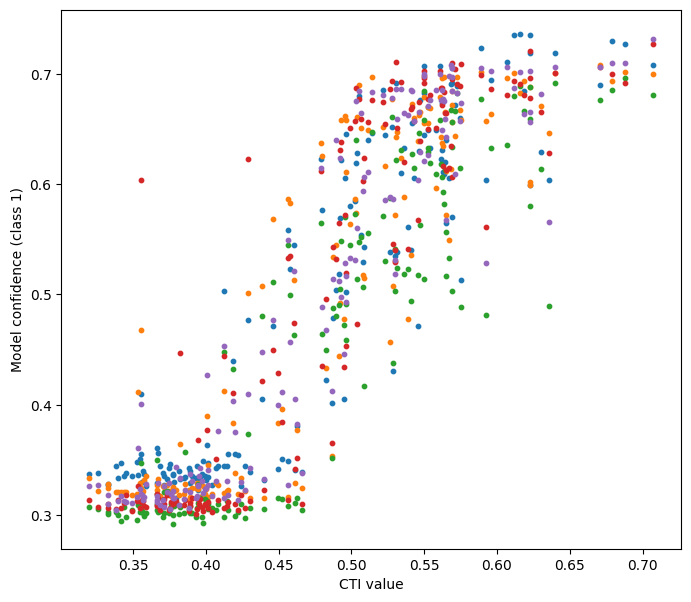

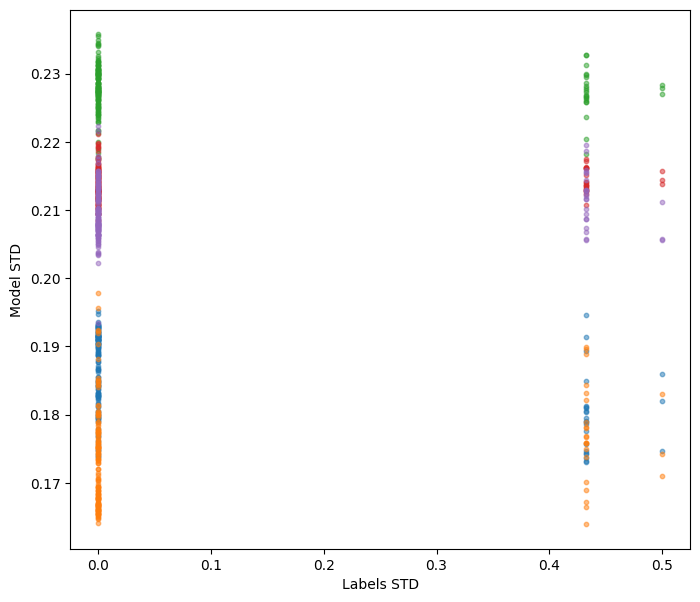

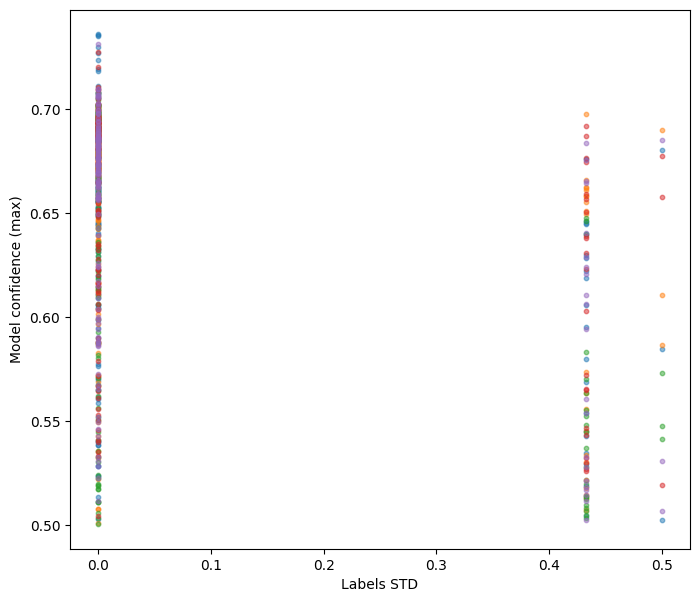

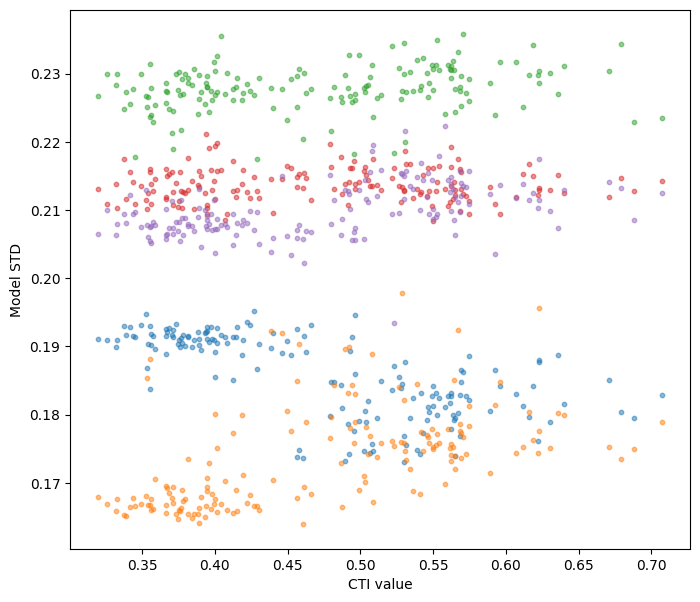

In [14]:
if LOSS == 'UANLL':
    figs = []
    axes = []
    for i in range(4):
        fig, ax = plt.subplots(figsize=(8, 7))
        figs.append(fig)
        axes.append(ax)
else:
    fig, ax = plt.subplots(figsize=(8, 7))

results = pd.DataFrame(np.zeros((3, 7)), columns = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5', 'Mean', 'Std'], index=['ACC', 'F1', 'AUCROC'])

acc = []
f1 = []
auc = []

test_dataset = ClassDataset(test_df, preload_transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for checkpoint in checkpoints:
    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    model.eval()

    labels_all = []
    outputs_sm_all = []
    predictions_all = []
    uncertainty_all = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            outputs_sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)

            labels_all.append(labels.cpu())
            outputs_sm_all.append(outputs_sm.cpu())
            predictions_all.append(outputs_sm.argmax(1).cpu())
            uncertainty_all.append(outputs[:, -1].cpu())

    labels_all = torch.cat(labels_all).numpy()
    outputs_sm_all = torch.cat(outputs_sm_all).numpy()
    predictions_all = torch.cat(predictions_all).numpy()
    uncertainty_all = torch.cat(uncertainty_all).numpy()

    accuracy_score_test = accuracy_score(labels_all, predictions_all)
    f1_score_test = f1_score(labels_all, predictions_all)
    roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

    if LOSS == 'UANLL':
        axes[0].scatter(mean_values, outputs_sm_all[:, 1], s=10)
        axes[0].set_xlabel('CTI value')
        axes[0].set_ylabel('Model confidence (class 1)')

        axes[1].scatter(std_labels, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
        axes[1].set_xlabel('Labels STD')
        axes[1].set_ylabel('Model STD')

        axes[2].scatter(std_labels, outputs_sm_all[torch.arange(len(outputs_sm_all)), outputs_sm_all.argmax(1)], s=10, alpha=0.5)
        axes[2].set_xlabel('Labels STD')
        axes[2].set_ylabel('Model confidence (max)')

        axes[3].scatter(mean_values, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
        axes[3].set_xlabel('CTI value')
        axes[3].set_ylabel('Model STD')
    else:
        ax.scatter(mean_values, outputs_sm_all[:, 1], s=10)
        ax.set_xlabel('CTI value')
        ax.set_ylabel('Model confidence (class 1)')

    acc.append(accuracy_score_test)
    f1.append(f1_score_test)
    auc.append(roc_auc_score_test)

results.loc['ACC'][:5] = acc
results.loc['F1'][:5] = f1
results.loc['AUCROC'][:5] = auc

results.loc['ACC'][5] = np.mean(acc)
results.loc['F1'][5] = np.mean(f1)
results.loc['AUCROC'][5] = np.mean(auc)

results.loc['ACC'][6] = np.std(acc)
results.loc['F1'][6] = np.std(f1)
results.loc['AUCROC'][6] = np.std(auc)


# MC-DO

In [15]:
if MODEL == 'ResDO':
    if LOSS == 'UANLL':
        figs = []
        axes = []
        for i in range(4):
            fig, ax = plt.subplots(figsize=(8, 7))
            figs.append(fig)
            axes.append(ax)
    else:
        fig, ax = plt.subplots(figsize=(8, 7))

    results_mc_do = pd.DataFrame(np.zeros((3, 7)), columns = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5', 'Mean', 'Std'], index=['ACC', 'F1', 'AUCROC'])

    acc = []
    f1 = []
    auc = []

    test_dataset = ClassDataset(test_df, preload_transform=transform)

    for checkpoint in checkpoints:
        seed = int(checkpoint.split('_')[-4])
        seed_everything(seed)

        labels_all = []
        outputs_sm_all = []
        uncertainty_all = []
        first = True

        model = ClassModel()
        model.load_state_dict(torch.load(checkpoint)['state_dict'])
        model.to('cuda')

        if MODEL == 'ResDO':
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.eval()
        else:
            model.eval()

        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        for j in range(NUM_TTA_FOR_SEED):

            with torch.no_grad():
                
                for i, (inputs, labels) in enumerate(test_loader):
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                    outputs = model(inputs)
                    outputs_sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)

                    if first:
                        labels_all.append(labels.cpu())
                        outputs_sm_all.append(outputs_sm.cpu())
                        uncertainty_all.append(outputs[:, -1].cpu())
                    else:
                        outputs_sm_all[i] += outputs_sm.cpu()
                        uncertainty_all[i] += outputs[:, -1].cpu()
            first = False

        labels_all = torch.cat(labels_all).numpy()
        outputs_sm_all = torch.cat(outputs_sm_all).numpy() / (NUM_TTA_FOR_SEED)
        uncertainty_all = torch.cat(uncertainty_all).numpy() / (NUM_TTA_FOR_SEED)
        predictions_all = outputs_sm_all.argmax(1)

        if LOSS == 'UANLL':
            axes[0].scatter(mean_values, outputs_sm_all[:, 1], s=10)
            axes[0].set_xlabel('CTI value')
            axes[0].set_ylabel('Model confidence (class 1)')

            axes[1].scatter(std_labels, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
            axes[1].set_xlabel('Labels STD')
            axes[1].set_ylabel('Model STD')

            axes[2].scatter(std_labels, outputs_sm_all[torch.arange(len(outputs_sm_all)), outputs_sm_all.argmax(1)], s=10, alpha=0.5)
            axes[2].set_xlabel('Labels STD')
            axes[2].set_ylabel('Model confidence (max)')

            axes[3].scatter(mean_values, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
            axes[3].set_xlabel('CTI value')
            axes[3].set_ylabel('Model STD')
        else:
            ax.scatter(mean_values, outputs_sm_all[:, 1], s=10)
            ax.set_xlabel('CTI value')
            ax.set_ylabel('Model confidence (class 1)')

        accuracy_score_test = accuracy_score(labels_all, predictions_all)
        f1_score_test = f1_score(labels_all, predictions_all)
        roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

        acc.append(accuracy_score_test)
        f1.append(f1_score_test)
        auc.append(roc_auc_score_test)

    results_mc_do.loc['ACC'][:5] = acc
    results_mc_do.loc['F1'][:5] = f1
    results_mc_do.loc['AUCROC'][:5] = auc

    results_mc_do.loc['ACC'][5] = np.mean(acc)
    results_mc_do.loc['F1'][5] = np.mean(f1)
    results_mc_do.loc['AUCROC'][5] = np.mean(auc)

    results_mc_do.loc['ACC'][6] = np.std(acc)
    results_mc_do.loc['F1'][6] = np.std(f1)
    results_mc_do.loc['AUCROC'][6] = np.std(auc)

# TTA

/root/miniconda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Seed set to 3
Seed set to 42
Seed set to 9
Seed set to 17
Seed set to 0
/tmp/ipykernel_25044/1793318105.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

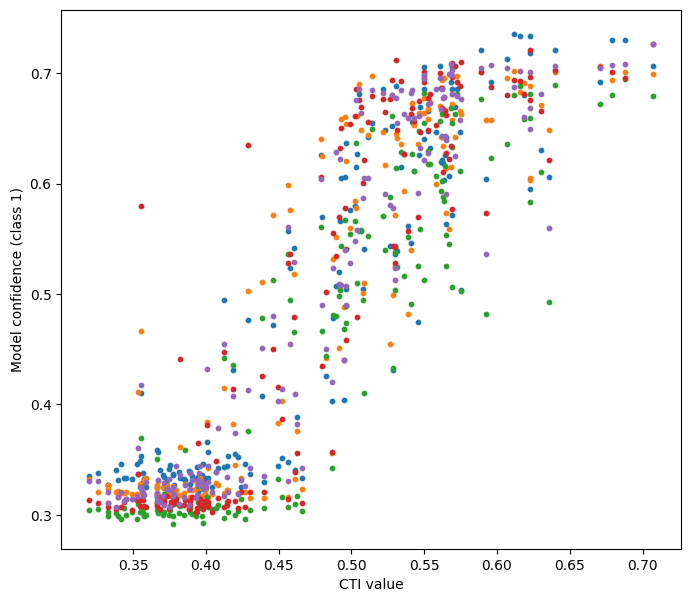

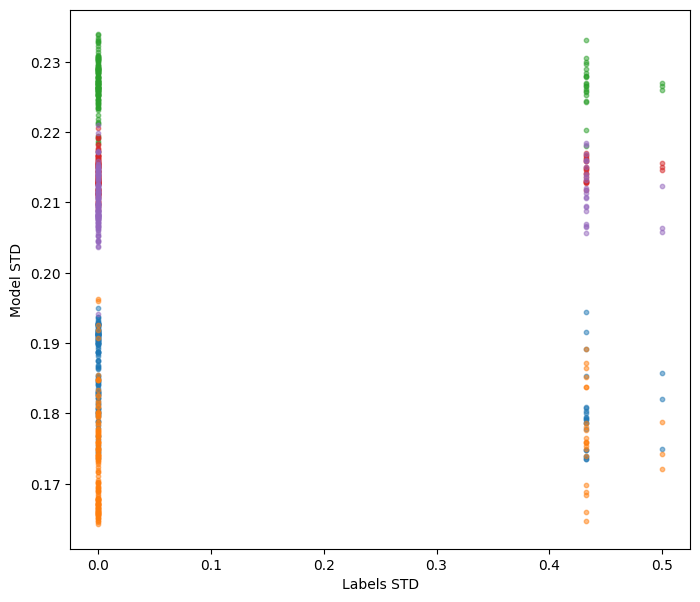

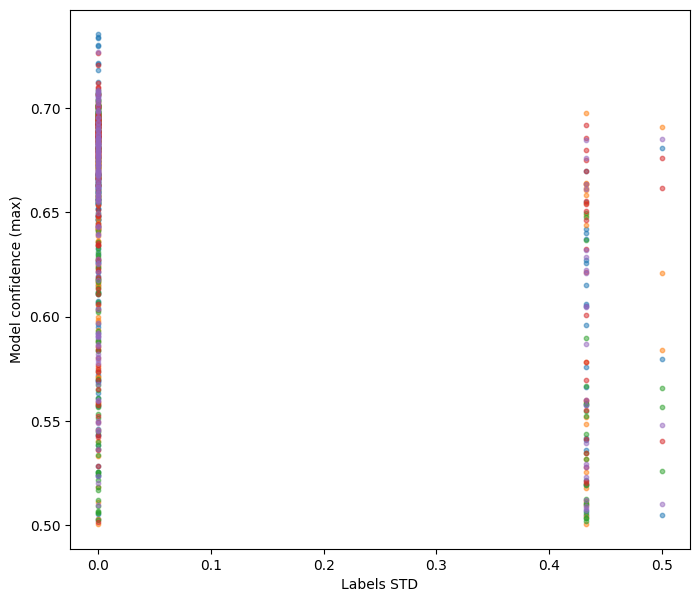

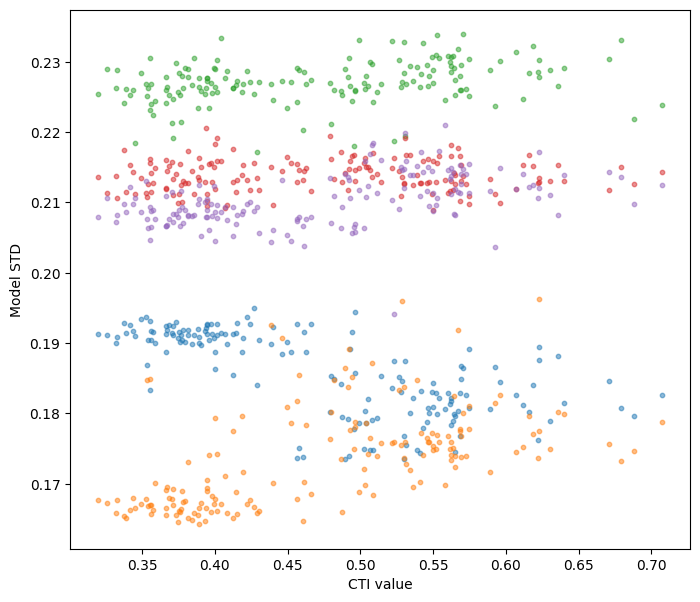

In [16]:
if LOSS == 'UANLL':
    figs = []
    axes = []
    for i in range(4):
        fig, ax = plt.subplots(figsize=(8, 7))
        figs.append(fig)
        axes.append(ax)
else:
    fig, ax = plt.subplots(figsize=(8, 7))

results_tta = pd.DataFrame(np.zeros((3, 7)), columns = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5', 'Mean', 'Std'], index=['ACC', 'F1', 'AUCROC'])

acc = []
f1 = []
auc = []

test_dataset = ClassDataset(test_df, preload_transform=transform)

for checkpoint in checkpoints:
    seed = int(checkpoint.split('_')[-4])
    seed_everything(seed)

    labels_all = []
    outputs_sm_all = []
    uncertainty_all = []
    first = True

    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    if MODEL == 'ResDO':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
    else:
        model.eval()
        
    if TRANSFORMS == 0:
        transform_tta = v2.Compose([
            v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        ])
    else:
        transform_tta = v2.Compose([
            v2.RandomResizedCrop(N, scale=(0.85, 1), antialias=True)
        ])

    test_dataset.set_transform(transform_tta)

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for j in range(NUM_TTA_FOR_SEED):

        with torch.no_grad():
            
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                outputs = model(inputs)
                outputs_sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)

                if first:
                    labels_all.append(labels.cpu())
                    outputs_sm_all.append(outputs_sm.cpu())
                    uncertainty_all.append(outputs[:, -1].cpu())
                else:
                    outputs_sm_all[i] += outputs_sm.cpu()
                    uncertainty_all[i] += outputs[:, -1].cpu()
        first = False

    labels_all = torch.cat(labels_all).numpy()
    outputs_sm_all = torch.cat(outputs_sm_all).numpy() / (NUM_TTA_FOR_SEED)
    uncertainty_all = torch.cat(uncertainty_all).numpy() / (NUM_TTA_FOR_SEED)
    predictions_all = outputs_sm_all.argmax(1)

    if LOSS == 'UANLL':
        axes[0].scatter(mean_values, outputs_sm_all[:, 1], s=10)
        axes[0].set_xlabel('CTI value')
        axes[0].set_ylabel('Model confidence (class 1)')

        axes[1].scatter(std_labels, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
        axes[1].set_xlabel('Labels STD')
        axes[1].set_ylabel('Model STD')

        axes[2].scatter(std_labels, outputs_sm_all[torch.arange(len(outputs_sm_all)), outputs_sm_all.argmax(1)], s=10, alpha=0.5)
        axes[2].set_xlabel('Labels STD')
        axes[2].set_ylabel('Model confidence (max)')

        axes[3].scatter(mean_values, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
        axes[3].set_xlabel('CTI value')
        axes[3].set_ylabel('Model STD')
    else:
        ax.scatter(mean_values, outputs_sm_all[:, 1], s=10)
        ax.set_xlabel('CTI value')
        ax.set_ylabel('Model confidence (class 1)')

    accuracy_score_test = accuracy_score(labels_all, predictions_all)
    f1_score_test = f1_score(labels_all, predictions_all)
    roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

    acc.append(accuracy_score_test)
    f1.append(f1_score_test)
    auc.append(roc_auc_score_test)

results_tta.loc['ACC'][:5] = acc
results_tta.loc['F1'][:5] = f1
results_tta.loc['AUCROC'][:5] = auc

results_tta.loc['ACC'][5] = np.mean(acc)
results_tta.loc['F1'][5] = np.mean(f1)
results_tta.loc['AUCROC'][5] = np.mean(auc)

results_tta.loc['ACC'][6] = np.std(acc)
results_tta.loc['F1'][6] = np.std(f1)
results_tta.loc['AUCROC'][6] = np.std(auc)

# Ensemble

/root/miniconda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Seed set to 3
Seed set to 42
Seed set to 9
Seed set to 17
Seed set to 0
/tmp/ipykernel_25044/507213171.py:90: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

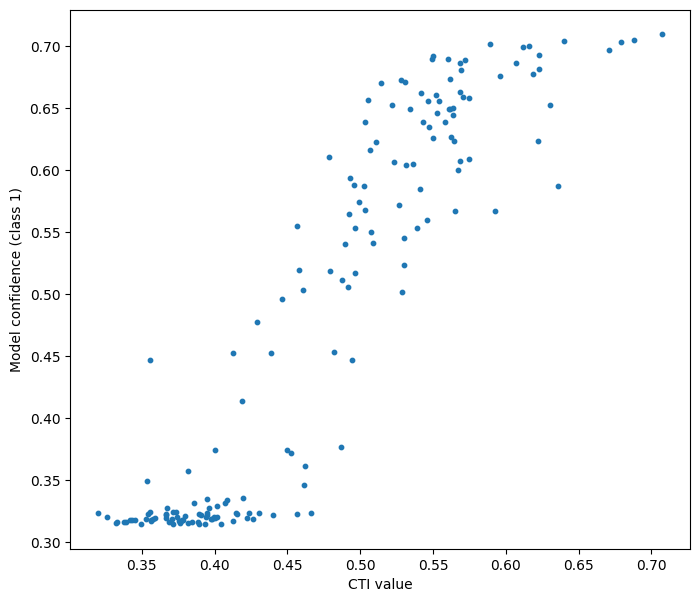

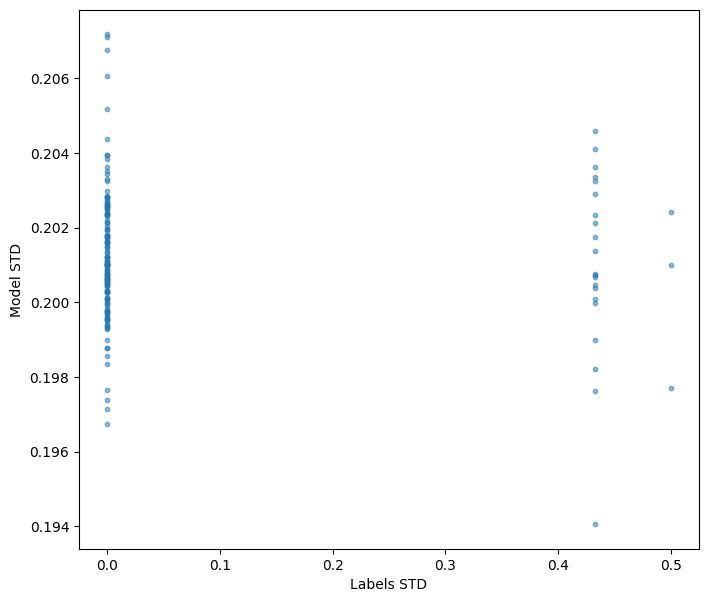

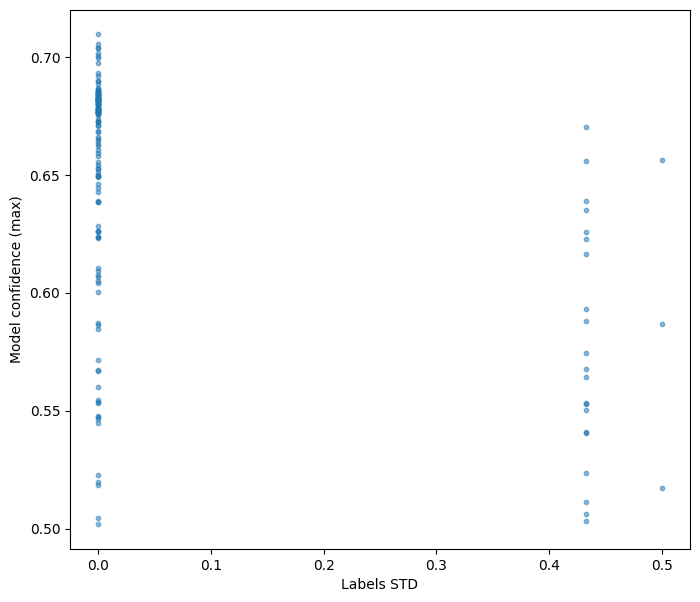

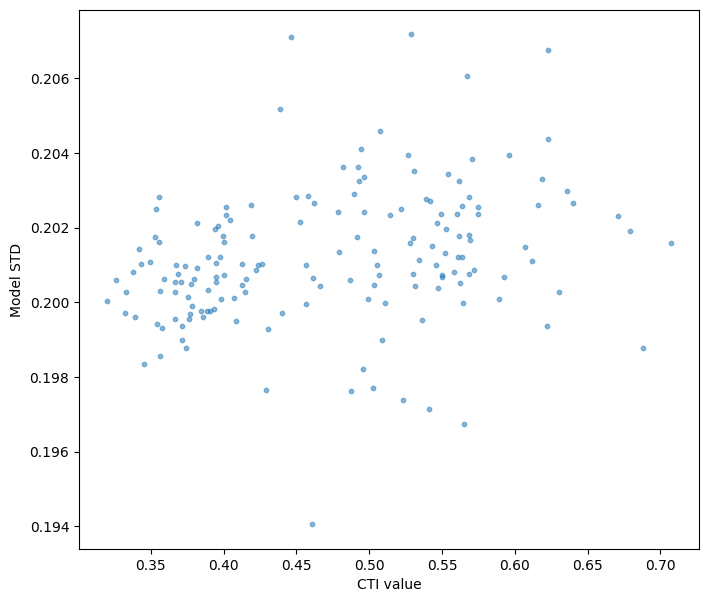

In [17]:
if LOSS == 'UANLL':
    figs = []
    axes = []
    for i in range(4):
        fig, ax = plt.subplots(figsize=(8, 7))
        figs.append(fig)
        axes.append(ax)
else:
    fig, ax = plt.subplots(figsize=(8, 7))

results_ens = pd.DataFrame(np.zeros((3, 1)), columns = ['Ens'], index=['ACC', 'F1', 'AUCROC'])

test_dataset = ClassDataset(test_df, preload_transform=transform)

labels_all = []
outputs_sm_all = []
uncertainty_all = []
first = True

w_acum = 0

for checkpoint in checkpoints:
    seed = int(checkpoint.split('_')[-4])
    seed_everything(seed)

    w = float(checkpoint.split('_')[-1][4:-5])
    w_acum += w

    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    if MODEL == 'ResDO':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
    else:
        model.eval()

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
            
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            outputs_sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)

            if first:
                labels_all.append(labels.cpu())
                outputs_sm_all.append(outputs_sm.cpu() * w)
                uncertainty_all.append(outputs[:, -1].cpu())
            else:
                outputs_sm_all[i] += outputs_sm.cpu() * w
                uncertainty_all[i] += outputs[:, -1].cpu()
        first = False

labels_all = torch.cat(labels_all).numpy()
outputs_sm_all = torch.cat(outputs_sm_all).numpy() / (w_acum)
uncertainty_all = torch.cat(uncertainty_all).numpy() / (len(SEED))
predictions_all = outputs_sm_all.argmax(1)

if LOSS == 'UANLL':
    axes[0].scatter(mean_values, outputs_sm_all[:, 1], s=10)
    axes[0].set_xlabel('CTI value')
    axes[0].set_ylabel('Model confidence (class 1)')

    axes[1].scatter(std_labels, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
    axes[1].set_xlabel('Labels STD')
    axes[1].set_ylabel('Model STD')

    axes[2].scatter(std_labels, outputs_sm_all[torch.arange(len(outputs_sm_all)), outputs_sm_all.argmax(1)], s=10, alpha=0.5)
    axes[2].set_xlabel('Labels STD')
    axes[2].set_ylabel('Model confidence (max)')

    axes[3].scatter(mean_values, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
    axes[3].set_xlabel('CTI value')
    axes[3].set_ylabel('Model STD')
else:
    ax.scatter(mean_values, outputs_sm_all[:, 1], s=10)
    ax.set_xlabel('CTI value')
    ax.set_ylabel('Model confidence (class 1)')

accuracy_score_test = accuracy_score(labels_all, predictions_all)
f1_score_test = f1_score(labels_all, predictions_all)
roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

results_ens.loc['ACC'][0] = accuracy_score_test
results_ens.loc['F1'][0] = f1_score_test
results_ens.loc['AUCROC'][0] = roc_auc_score_test


# TTA and Ensemble

/root/miniconda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Seed set to 3
Seed set to 42
Seed set to 9
Seed set to 17
Seed set to 0
/tmp/ipykernel_25044/535764826.py:107: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

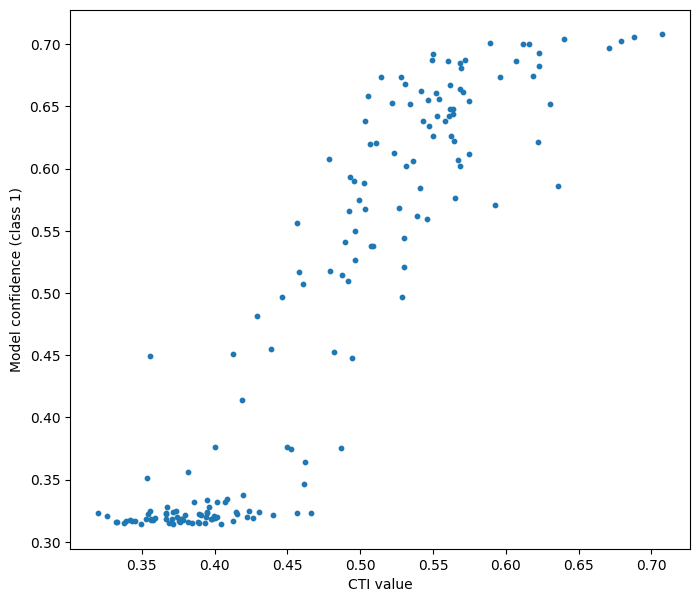

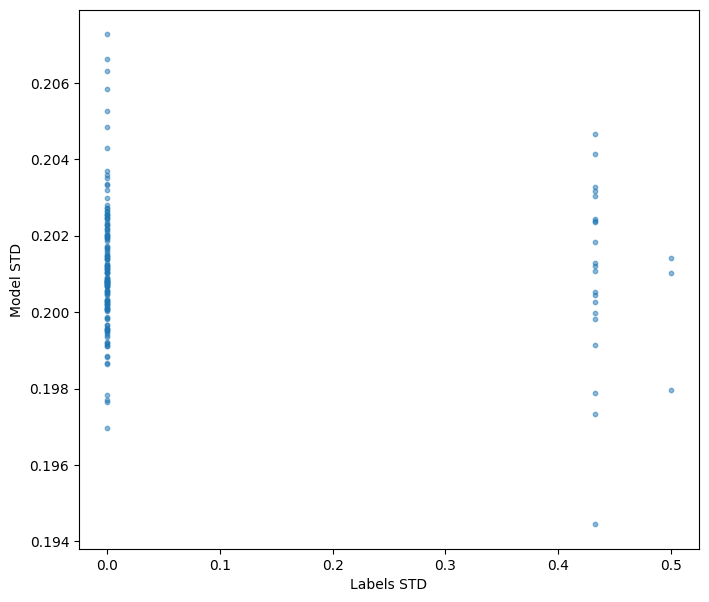

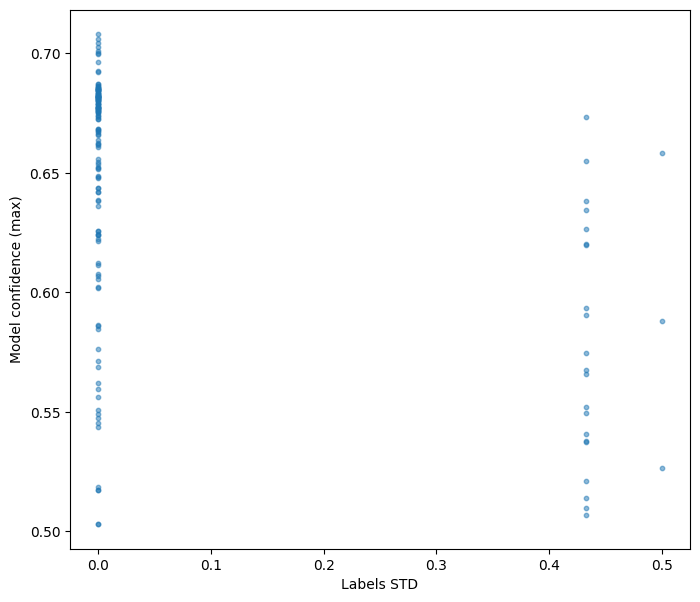

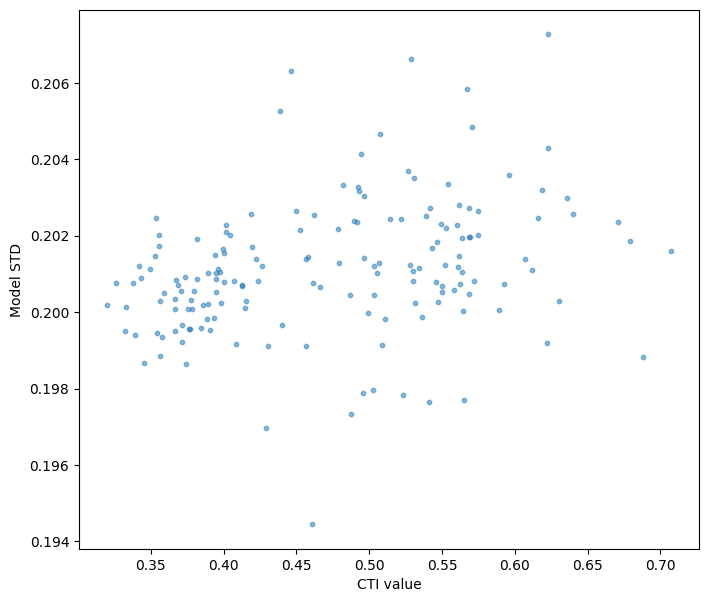

In [18]:
if LOSS == 'UANLL':
    figs = []
    axes = []
    for i in range(4):
        fig, ax = plt.subplots(figsize=(8, 7))
        figs.append(fig)
        axes.append(ax)
else:
    fig, ax = plt.subplots(figsize=(8, 7))

results_tta_ens = pd.DataFrame(np.zeros((3, 1)), columns = ['TTA_Ens'], index=['ACC', 'F1', 'AUCROC'])

test_dataset = ClassDataset(test_df, preload_transform=transform)

labels_all = []
outputs_sm_all = []
uncertainty_all = []
first = True

w_acum = 0

for checkpoint in checkpoints:
    seed = int(checkpoint.split('_')[-4])
    seed_everything(seed)

    w = float(checkpoint.split('_')[-1][4:-5])
    w_acum += w

    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    if MODEL == 'ResDO':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
    else:
        model.eval()
        
    if TRANSFORMS == 0:
        transform_tta = v2.Compose([
            v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        ])
    else:
        transform_tta = v2.Compose([
            v2.RandomResizedCrop(N, scale=(0.85, 1), antialias=True)
        ])

    test_dataset.set_transform(transform_tta)

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for j in range(NUM_TTA_FOR_SEED):

        with torch.no_grad():
            
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                outputs = model(inputs)
                outputs_sm = nn.functional.softmax(outputs[:, :N_CLASSES], dim=1)

                if first:
                    labels_all.append(labels.cpu())
                    outputs_sm_all.append(outputs_sm.cpu() * w)
                    uncertainty_all.append(outputs[:, -1].cpu())
                else:
                    outputs_sm_all[i] += outputs_sm.cpu() * w
                    uncertainty_all[i] += outputs[:, -1].cpu()
        first = False

labels_all = torch.cat(labels_all).numpy()
outputs_sm_all = torch.cat(outputs_sm_all).numpy() / (w_acum * NUM_TTA_FOR_SEED)
uncertainty_all = torch.cat(uncertainty_all).numpy() / (len(SEED) * NUM_TTA_FOR_SEED)
predictions_all = outputs_sm_all.argmax(1)

if LOSS == 'UANLL':
    axes[0].scatter(mean_values, outputs_sm_all[:, 1], s=10)
    axes[0].set_xlabel('CTI value')
    axes[0].set_ylabel('Model confidence (class 1)')

    axes[1].scatter(std_labels, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
    axes[1].set_xlabel('Labels STD')
    axes[1].set_ylabel('Model STD')

    axes[2].scatter(std_labels, outputs_sm_all[torch.arange(len(outputs_sm_all)), outputs_sm_all.argmax(1)], s=10, alpha=0.5)
    axes[2].set_xlabel('Labels STD')
    axes[2].set_ylabel('Model confidence (max)')

    axes[3].scatter(mean_values, np.exp(uncertainty_all) ** 0.5, s=10, alpha=0.5)
    axes[3].set_xlabel('CTI value')
    axes[3].set_ylabel('Model STD')
else:
    ax.scatter(mean_values, outputs_sm_all[:, 1], s=10)
    ax.set_xlabel('CTI value')
    ax.set_ylabel('Model confidence (class 1)')

accuracy_score_test = accuracy_score(labels_all, predictions_all)
f1_score_test = f1_score(labels_all, predictions_all)
roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

acc.append(accuracy_score_test)
f1.append(f1_score_test)
auc.append(roc_auc_score_test)

results_tta_ens.loc['ACC'][0] = accuracy_score_test
results_tta_ens.loc['F1'][0] = f1_score_test
results_tta_ens.loc['AUCROC'][0] = roc_auc_score_test


In [19]:
print(MODEL, LOSS, 'Clean')
display(results)
if MODEL == 'ResDO':
    print(MODEL, LOSS, 'MC-DO')
    display(results_mc_do)
print(MODEL, LOSS, 'TTA')
display(results_tta)
print(MODEL, LOSS, 'Ens')
display(results_ens)
print(MODEL, LOSS, 'TTA with Ens')
display(results_tta_ens)

Res UANLL Clean


,Run 1,Run 2,Run 3,Run 4,Run 5,Mean,Std
ACC,0.903030,0.896970,0.921212,0.915152,0.939394,0.915152,0.014845
F1,0.893333,0.887417,0.906475,0.906667,0.932432,0.905265,0.015507
AUCROC,0.971769,0.965278,0.975996,0.984149,0.991093,0.977657,0.009092


Res UANLL TTA


,Run 1,Run 2,Run 3,Run 4,Run 5,Mean,Std
ACC,0.909091,0.884848,0.921212,0.909091,0.933333,0.911515,0.016081
F1,0.899329,0.874172,0.906475,0.900662,0.926174,0.901363,0.016648
AUCROC,0.973581,0.964221,0.976600,0.982790,0.991244,0.977687,0.009047


Res UANLL Ens


,Ens
ACC,0.915152
F1,0.907895
AUCROC,0.987017


Res UANLL TTA with Ens


,TTA_Ens
ACC,0.909091
F1,0.900662
AUCROC,0.987168
